```
Name: Train&Validation.ipynb
Description: Train and validation proposed NEtwork
Author: Behzad Valipour Sh. <behzad.valipour@outlook.com>
Date: 04.09.2022
```
```
MIT License

Copyright (c) 2022 Behzad Valipour Sh.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

In [1]:
from src import LoadImageData, PatchWiseClassModel01, PatchWiseClassModel02,_stretch_im, 

import torch
from torch import nn, optim
import torchmetrics

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report,roc_curve,precision_recall_curve,roc_auc_score ,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from random import sample
import numpy as np
import os,sys

In [4]:
train_transform = A.Compose([A.RandomRotate90(),
                             A.HorizontalFlip(),
                             A.VerticalFlip(),
                             ToTensorV2(),
                            ])

valid_transform = A.Compose([ToTensorV2()])

In [5]:
# Constants
n_epochs = 50
batch_size = 2

In [6]:
train_data = LoadImageData('../data/train_data.geojson', '../data/Sentinel-2_B4328_10m.tif',transform = train_transform)
validation_data = LoadImageData('../data/valid_data.geojson', '../data/Sentinel-2_B4328_10m.tif',transform = valid_transform)
test_data = LoadImageData('../data/test_data.geojson', '../data/Sentinel-2_B4328_10m.tif',transform = valid_transform)

In [7]:
train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=20,pin_memory=True)
validation_loader = DataLoader(dataset=validation_data,batch_size=batch_size,shuffle=False,num_workers=20,pin_memory=True)
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,num_workers=20,pin_memory=True)

In [16]:
class PatchWiseClassModel(pl.LightningModule):
    def __init__(self,learning_rate = 0.01):
        super(PatchWiseClassModel,self).__init__()
        
        
        self.model = PatchWiseClassModel02()
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.Accuracy = torchmetrics.Accuracy()
        self.Accuracy_val = torchmetrics.Accuracy()
        self.Accuracy_test = torchmetrics.Accuracy()
        self.save_hyperparameters()
        
    def forward(self,inPut):
        return self.model(inPut)
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        
        pred = self(x)
        loss = self.loss(pred,y)
        acc = self.Accuracy(pred,y.int())
        self.log('Train_Loss', loss, on_epoch=True, on_step=True)
        self.log('Train_ACC_Step',acc)
        return loss
    
    def training_epoch_end(self, outputs):
        self.log('train_ACC_epoch', self.Accuracy.compute(),prog_bar=True)
        self.Accuracy.reset()
        
    def validation_step(self, batch, batch_idx):
        x,y = batch
        
        pred = self(x)
        loss = self.loss(pred,y)
        acc = self.Accuracy_val(pred,y.int())
        self.log('validation_Loss', loss, on_epoch=True, on_step=True)
        self.log('validation_ACC_Step',acc)
        return loss
    
    def validation_epoch_end(self, outputs):
        self.log('val_ACC_epoch', self.Accuracy_val.compute(),prog_bar=True)
        self.Accuracy_val.reset()
        
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        
        pred = self(x)
        loss = self.loss(pred,y)
        acc = self.Accuracy_test(pred,y.int())
        self.log('Test_Loss', loss, on_epoch=True, on_step=True)
        self.log('Test_ACC_Step',acc)
        return loss
    
    def test_epoch_end(self, outputs):
        self.log('test_ACC_epoch', self.Accuracy_test.compute())
        self.Accuracy_test.reset()
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        return optimizer

In [17]:
model = PatchWiseClassModel(learning_rate=0.0002)
ckpt_dir = "/scicore/home/roeoesli/valipo0000/training/tokyo/model"
early_stop_callback = EarlyStopping(monitor="val_ACC_epoch", patience=10,min_delta=0.01, verbose=True, mode="max")
ckpt_callback = pl.callbacks.ModelCheckpoint(filename="road-classifier-0.0.1_{epoch:02d}-{validation_Loss_epoch:.6f}",monitor='val_ACC_epoch',mode='max',verbose=True)
trainer = pl.Trainer(default_root_dir=ckpt_dir, gpus=1,
                        callbacks=[ckpt_callback,early_stop_callback],
                        log_every_n_steps=1,
                        max_epochs=n_epochs,
                        fast_dev_run=False)
trainer.fit(model, train_dataloaders=train_loader,val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params
--------------------------------------------------------
0 | model         | PatchWiseClassModel02 | 33.7 K
1 | loss          | CrossEntropyLoss      | 0     
2 | Accuracy      | Accuracy              | 0     
3 | Accuracy_val  | Accuracy              | 0     
4 | Accuracy_test | Accuracy              | 0     
--------------------------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved. New best score: 0.543
Epoch 0, global step 1500: 'val_ACC_epoch' reached 0.54259 (best 0.54259), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=00-validation_Loss_epoch=1.164196.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.037 >= min_delta = 0.01. New best score: 0.580
Epoch 1, global step 3000: 'val_ACC_epoch' reached 0.58000 (best 0.58000), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=01-validation_Loss_epoch=1.105846.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 4500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.019 >= min_delta = 0.01. New best score: 0.599
Epoch 3, global step 6000: 'val_ACC_epoch' reached 0.59852 (best 0.59852), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=03-validation_Loss_epoch=0.984416.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.016 >= min_delta = 0.01. New best score: 0.614
Epoch 4, global step 7500: 'val_ACC_epoch' reached 0.61444 (best 0.61444), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=04-validation_Loss_epoch=0.973414.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.060 >= min_delta = 0.01. New best score: 0.674
Epoch 5, global step 9000: 'val_ACC_epoch' reached 0.67444 (best 0.67444), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=05-validation_Loss_epoch=0.911657.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 10500: 'val_ACC_epoch' reached 0.68333 (best 0.68333), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=06-validation_Loss_epoch=0.861521.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 12000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 13500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.014 >= min_delta = 0.01. New best score: 0.688
Epoch 9, global step 15000: 'val_ACC_epoch' reached 0.68815 (best 0.68815), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=09-validation_Loss_epoch=0.816131.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.013 >= min_delta = 0.01. New best score: 0.701
Epoch 10, global step 16500: 'val_ACC_epoch' reached 0.70148 (best 0.70148), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=10-validation_Loss_epoch=0.842142.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 18000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 19500: 'val_ACC_epoch' reached 0.71000 (best 0.71000), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=12-validation_Loss_epoch=0.772099.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 21000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.023 >= min_delta = 0.01. New best score: 0.725
Epoch 14, global step 22500: 'val_ACC_epoch' reached 0.72481 (best 0.72481), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=14-validation_Loss_epoch=0.769759.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 24000: 'val_ACC_epoch' reached 0.72963 (best 0.72963), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=15-validation_Loss_epoch=0.754504.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 25500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 27000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.021 >= min_delta = 0.01. New best score: 0.746
Epoch 18, global step 28500: 'val_ACC_epoch' reached 0.74593 (best 0.74593), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=18-validation_Loss_epoch=0.731314.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 30000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 31500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 33000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 34500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 36000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 37500: 'val_ACC_epoch' reached 0.75296 (best 0.75296), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=24-validation_Loss_epoch=0.736993.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_ACC_epoch improved by 0.010 >= min_delta = 0.01. New best score: 0.756
Epoch 25, global step 39000: 'val_ACC_epoch' reached 0.75593 (best 0.75593), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=25-validation_Loss_epoch=0.705683.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 40500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 42000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 43500: 'val_ACC_epoch' reached 0.76222 (best 0.76222), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=28-validation_Loss_epoch=0.684784.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 45000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 46500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 48000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 49500: 'val_ACC_epoch' reached 0.76519 (best 0.76519), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=32-validation_Loss_epoch=0.694301.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 51000: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 52500: 'val_ACC_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_ACC_epoch did not improve in the last 10 records. Best score: 0.756. Signaling Trainer to stop.
Epoch 35, global step 54000: 'val_ACC_epoch' reached 0.76593 (best 0.76593), saving model to '/scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=35-validation_Loss_epoch=0.671447.ckpt' as top 1


In [18]:
trainer.test(ckpt_path='best',dataloaders=test_loader)

Restoring states from the checkpoint path at /scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=35-validation_Loss_epoch=0.671447.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /scicore/home/roeoesli/valipo0000/training/tokyo/model/lightning_logs/version_52783421/checkpoints/road-classifier-0.0.1_epoch=35-validation_Loss_epoch=0.671447.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test_ACC_Step                0.75
     Test_Loss_epoch         0.71528559923172
     test_ACC_epoch                0.75
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test_Loss_epoch': 0.71528559923172,
  'Test_ACC_Step': 0.75,
  'test_ACC_epoch': 0.75}]

In [32]:
model_ = PatchWiseClassModel()
train_model = model_.load_from_checkpoint(checkpoint_path='../model/lightning_logs/version_3/checkpoints/road-classifier-0.0.1_epoch=35-validation_Loss_epoch=0.671447.ckpt')

In [33]:
with torch.no_grad():
    y_pred_list = []
    y_list = []
    for images_, labels_ in tqdm(test_loader,position=0, leave=True):
        y_predicted = torch.argmax(train_model(images_),1)
        y_pred_list.append(y_predicted.cpu().numpy())
        y_list.append(labels_.cpu().numpy())

y_test = np.concatenate(y_list)
y_predict = np.concatenate(y_pred_list)

100%|██████████████████████████████████████████████████| 150/150 [00:01<00:00, 76.79it/s]


In [34]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87        50
           1       0.86      0.84      0.85        61
           2       0.35      0.27      0.31        44
           3       0.61      0.80      0.69        41
           4       0.92      0.93      0.92        58
           5       0.70      0.72      0.71        46

    accuracy                           0.75       300
   macro avg       0.72      0.73      0.73       300
weighted avg       0.74      0.75      0.74       300



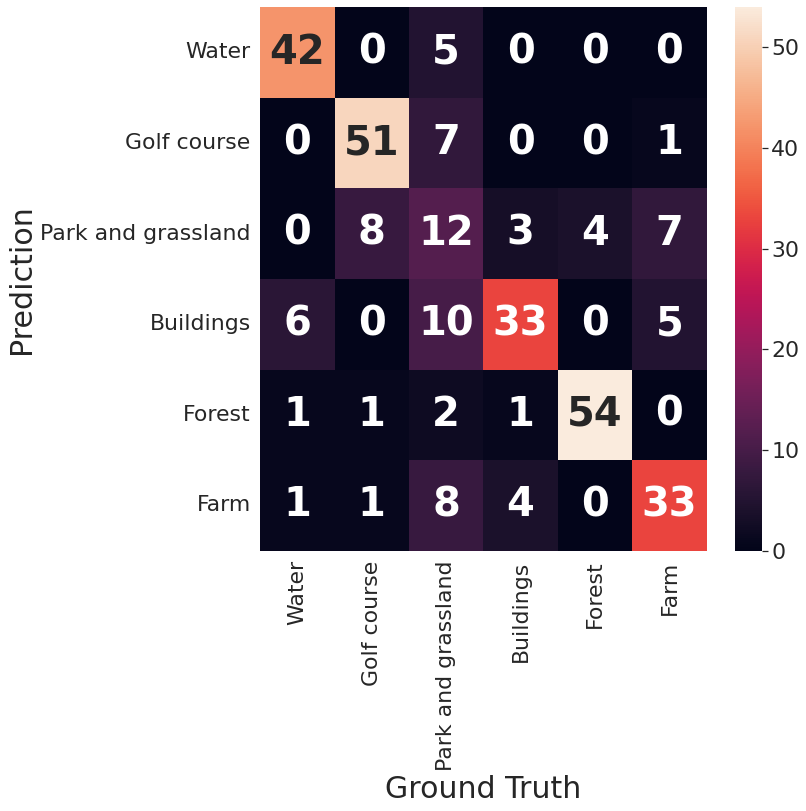

In [35]:
# sns.set_context('talk')
sns.set(font_scale=2)
cm = confusion_matrix(y_predict,y_test)
_, ax = plt.subplots(figsize=(10,10))
labels = ["Water", "Golf course", "Park and grassland", "Buildings", "Forest", "Farm"]
ax = sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"},xticklabels=labels,yticklabels=labels)

ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
plt.show()

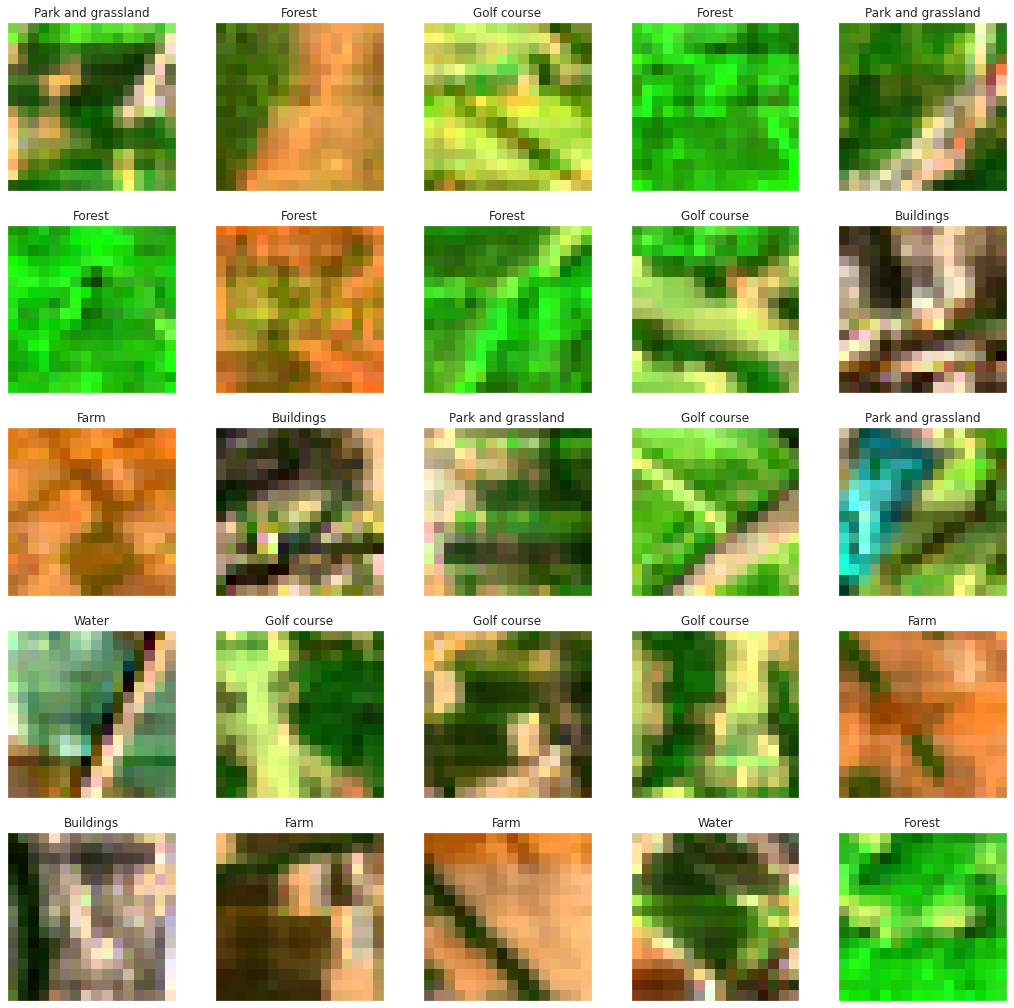

In [36]:
sns.set(font_scale=1)
with torch.no_grad():
    plt.figure(figsize=(18,18))
    for i, j in enumerate(sample(range(0, 300), 50)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        code = torch.argmax(train_model(test_data[j][0].unsqueeze(0))).to('cpu').numpy()
        plt.imshow(np.clip(_stretch_im(np.moveaxis(test_data[j][0].cpu().detach().numpy(),0,-1)[...,:3],0),0,1))
        if code == 0:
            plt.title('Water')
        elif code == 1:
            plt.title('Golf course')
        elif code == 2:
            plt.title('Park and grassland')
        elif code == 3:
            plt.title('Buildings')
        elif code == 4:
            plt.title('Forest')
        elif code == 5:
            plt.title('Farm')
        if i==24:
            break

# Conclusion

Three models were trained with the same learning rate, but different `Architecture` and `Batch size` was changed. 

V1: PatchWiseClassModel01, Batch Size: 8

V2: PatchWiseClassModel02, Batch Size: 8

V3: PatchWiseClassModel02, Batch size: 2

__As conclusion, I can say for few number of the data (3K or less) for each class, it is better to use smal Batch size since model can learn in less Epochs__

__Validation accuracy for 3 model (V1: Orange, V2:Blue, V3: Red )__
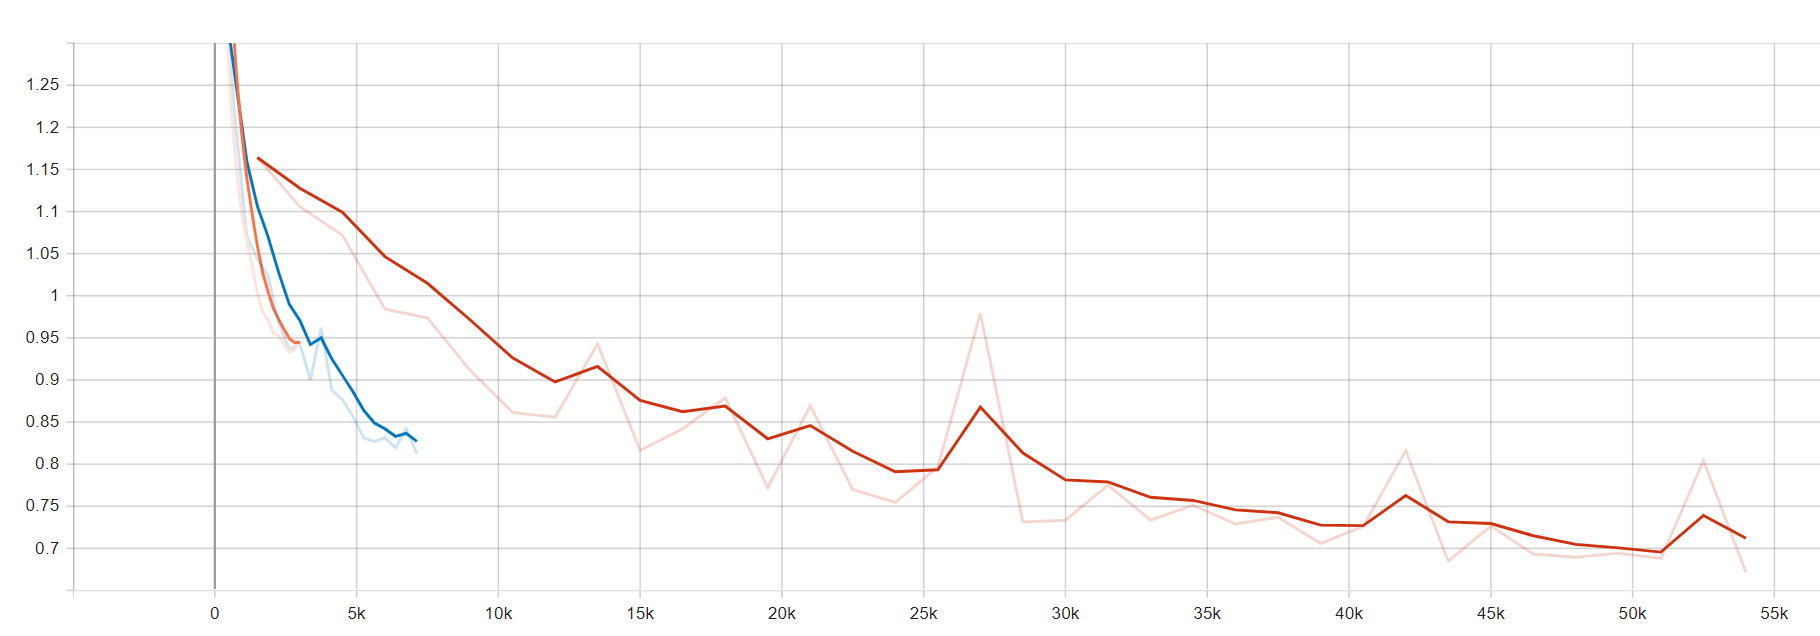

__Validation loss for 3 model (V1: Orange, V2:Blue, V3: Red )__
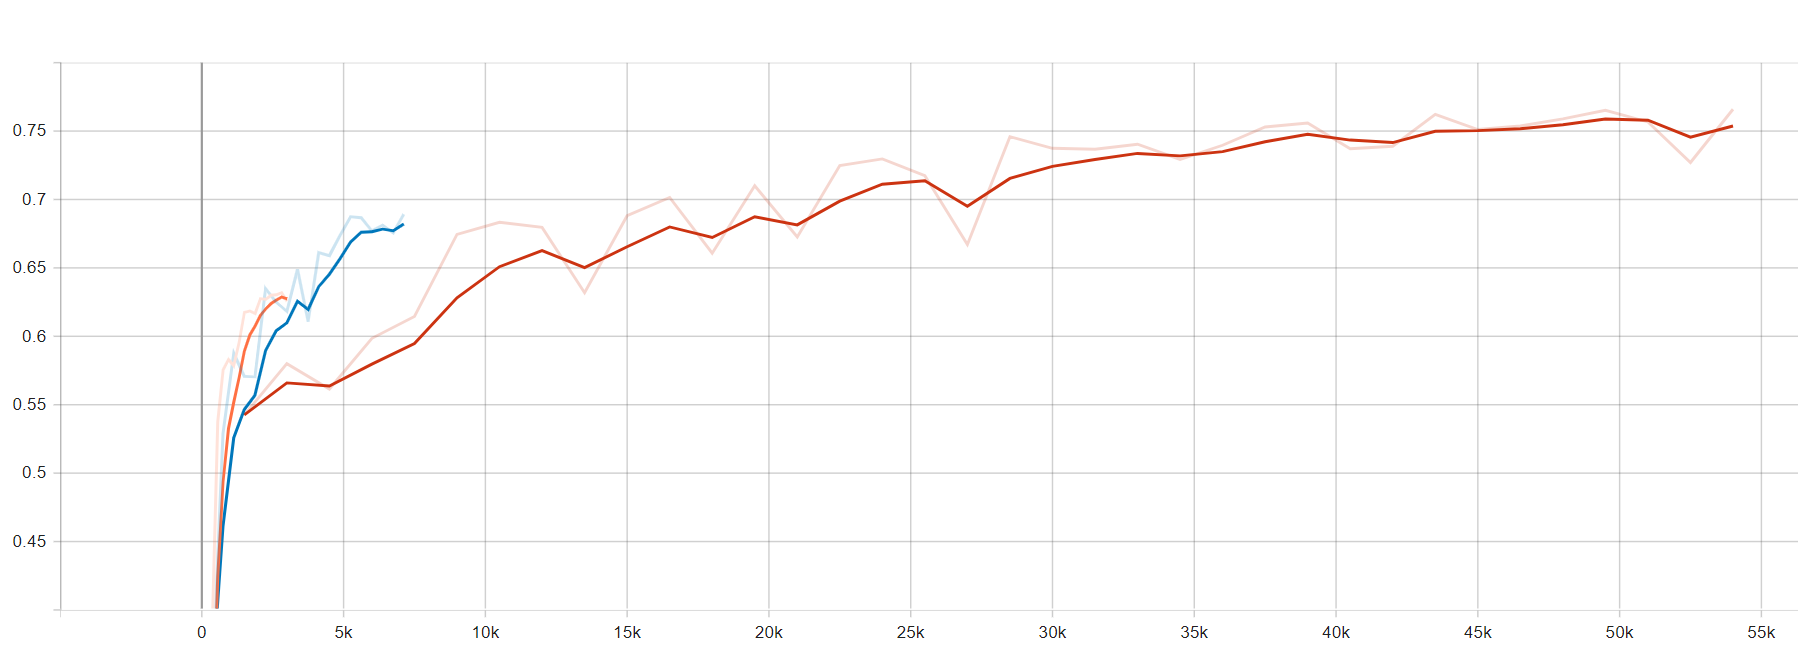